###**Importing required libraries**

In [535]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing,load_diabetes,load_iris
from sklearn.metrics import r2_score,classification_report,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### **Score functions**

In [536]:
def mean_sqr_err(y_test,y_pred): # Calculates the Mean Square Error
  val = np.mean((y_test-y_pred)**2)
  return val
def mean_abs_err(y_test,y_pred): # Calculates the Mean Absolute Error
  val = np.mean(np.abs(y_test-y_pred))
  return val
def root_mean_sqr_err(y_test,y_pred): # Calculates the Root mean Square Error
  val = np.sqrt(np.mean((y_test-y_pred)**2))
  return val

# **Task 1**

### **Linear Regression**
$$
\hat{y} = X\beta
$$

Cost function (MSE):

$$
J(\beta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \|y - X\beta\|^2
$$


**Ordinary Least Squares**

In [537]:
class LinReg_OLS:
  def __init__(self):
    self.coefficient = None
  def fit(self,X_train,y_train):
    X_mod = np.insert(X_train,0,1,axis=1)
    self.coefficient = np.linalg.inv(X_mod.T.dot(X_mod)).dot(X_mod.T).dot(y_train)
  def predict(self,X_test):
    y_pred = np.insert(X_test,0,1,axis=1).dot(self.coefficient)
    return y_pred
  def get_params(self):
    return self.coefficient

**Gradient Descent(Mini-Batch)**

In [538]:
class LinReg_GD:
    def __init__(self, lr, n_iters, batch_size=32):
        self.lr = lr
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.coefficients = None

    def fit(self, X_train, y_train):
        X_mod = np.insert(X_train, 0, 1, axis=1)
        y_train = y_train.reshape(-1, 1)
        n_samples, n_features = X_mod.shape
        self.coefficients = np.zeros((n_features, 1))
        for _ in range(self.n_iters):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X_mod[indices]
            y_shuffled = y_train[indices]
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                predictions = X_batch @ self.coefficients
                errors = predictions - y_batch
                gradients = (2 / X_batch.shape[0]) * X_batch.T @ errors
                self.coefficients -= self.lr * gradients

    def predict(self, X_train):
        X_mod = np.insert(X_train, 0, 1, axis=1)
        return X_mod @ self.coefficients

    def get_params(self):
        return self.coefficients


### **Lasso Regression**
$$
J(\beta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
$$

Or, using vector notation:

$$
J(\beta) = \|y - X\beta\|^2 + \lambda \|\beta\|_1
$$

Where:
- $\|y - X\beta\|^2 = (y - X\beta)^\top (y - X\beta) = \sum_{i=1}^{n} (y_i - X_i^\top \beta)^2$
- $\|\beta\|_1 = \sum_{j=1}^{p} |\beta_j|$

- $\lambda \geq 0 $

In [539]:
class LassoReg:
    def __init__(self, lr, lambda_par, n_iters):
        self.lr = lr
        self.lambda_par = lambda_par
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.random.uniform(1, 10, size=n)
        self.bias = 1
        for _ in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias
            error = y_predicted - y
            dw = (2 / m) * np.dot(X.T, error) + self.lambda_par * np.sign(self.weights)
            db = (2 / m) * np.sum(error)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def get_params(self):
        return self.weights, self.bias

###**Ridge Regression**
$$
J(\beta) = \|y - X\beta\|^2 + \lambda \|\beta\|_2^2
$$

Where:
- $\|\beta\|_2^2 = \sum_{j=1}^{p} \beta_j^2 $
- $\lambda \geq 0  $  is the regularization parameter

In [540]:
class RidgeReg:
    def __init__(self, lr,lambda_par, n_iters):
        self.lambda_par = lambda_par
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(1, 10, size=n_features)
        self.bias = 1
        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (-2 / n_samples) * np.dot(X.T, (y - y_pred)) + 2 * self.lambda_par * self.weights
            db = (-2 / n_samples) * np.sum(y - y_pred)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def get_params(self):
        return self.weights, self.bias

###**K-Means Clustering**

In [541]:
class KMeans:
    def __init__(self, k_clusters, max_iters, tol=1e-4):
        self.k_clusters = k_clusters
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.X = X
        m, n = X.shape
        random_indices = np.random.choice(m, self.k_clusters, replace=False)
        self.centroids = X[random_indices]
        for i in range(self.max_iters):
            self.labels = self.assign_clusters(X)
            new_centroids = np.array([
                X[self.labels == j].mean(axis=0) for j in range(self.k_clusters)
            ])
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids
        return self

    def assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def predict(self, X):
        return self.assign_clusters(X)

    def wcss(self):
        return np.sum([
            np.sum((self.X[self.labels == i] - self.centroids[i]) ** 2)
            for i in range(self.k_clusters)
        ])

###**Decision Trees**

**Function to create Nodes in the lassification Tree**

In [542]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index # for decision nodes
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value # for leaf nodes

**Classification**

In [543]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0): # Important function to build tree recursively
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features): # To calculate the best split of the features
        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y): # Calculation by entropy formula
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y): # Calculation by Gini Impurity
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):  # To make predictions on a dataset
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):  # To make prediction on a single datapoint
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

**Function to create node for the Regression Tree**

In [544]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        self.feature_index = feature_index # For decision node
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        self.value = value # For leaf node

**Regression**

In [545]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0): # Important function to build tree recursively
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["var_red"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["var_red"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features): # To calculate the best split of the features
        best_split = {}
        max_var_red = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def variance_reduction(self, parent, l_child, r_child): # To calculate variance reduction for selecting best features
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction

    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X): # To make predictions on a dataset
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree): # To make predictions on a single datapoint
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

#**Task 2**

### **Loading the Datasets**

In [546]:
data = fetch_california_housing()
X1 = pd.DataFrame(data.data, columns=data.feature_names)
y1 = data.target
df1 = pd.concat([X1,pd.DataFrame(y1,columns=["Target"])],axis=1)
df1

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [547]:
X1.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0


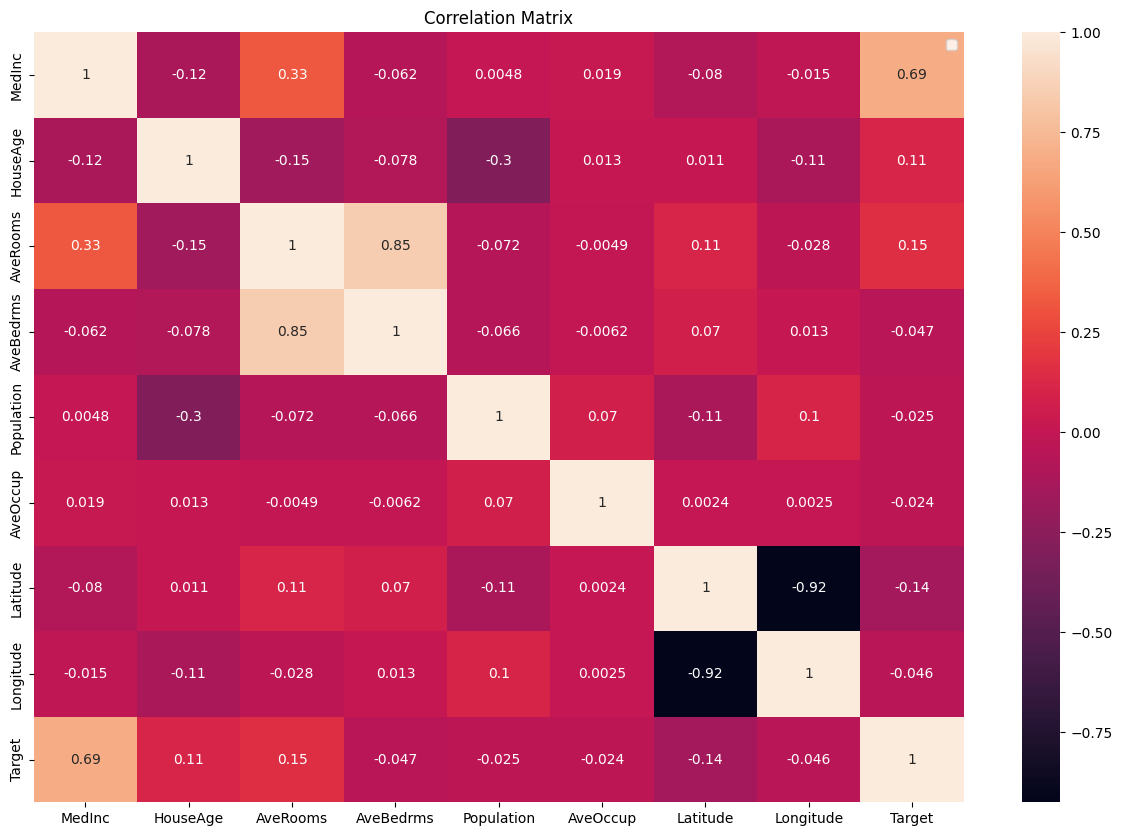

In [548]:
plt.figure(figsize=(15,10))
sns.heatmap(df1.corr(), annot=True)
plt.title("Correlation Matrix")
plt.legend()
plt.show()

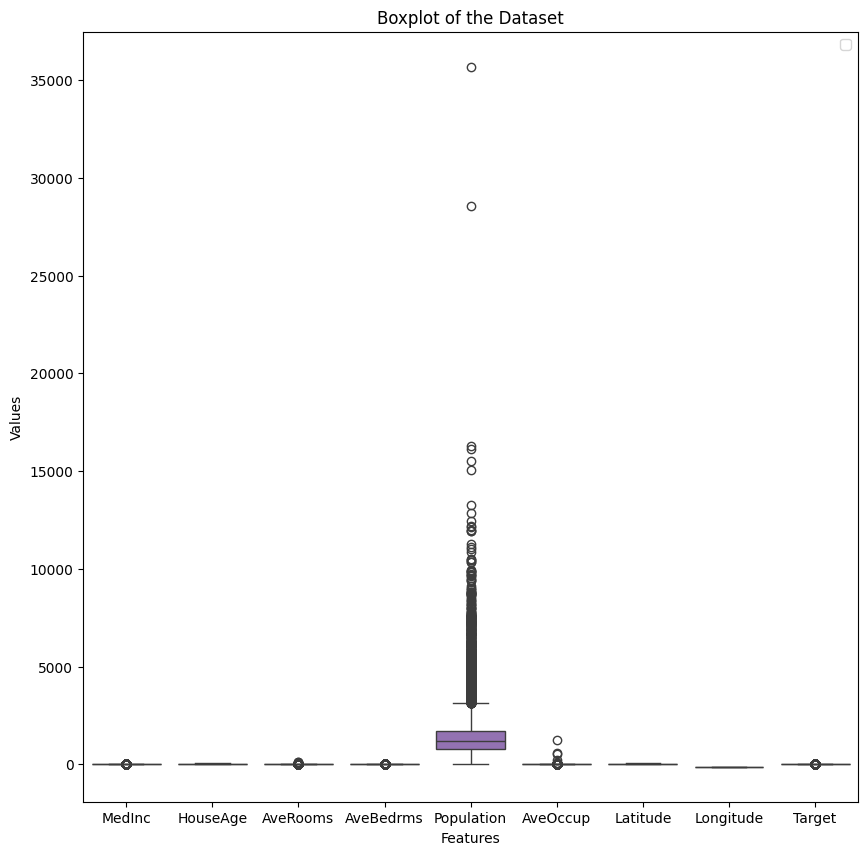

In [549]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df1)
plt.title("Boxplot of the Dataset")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.show()

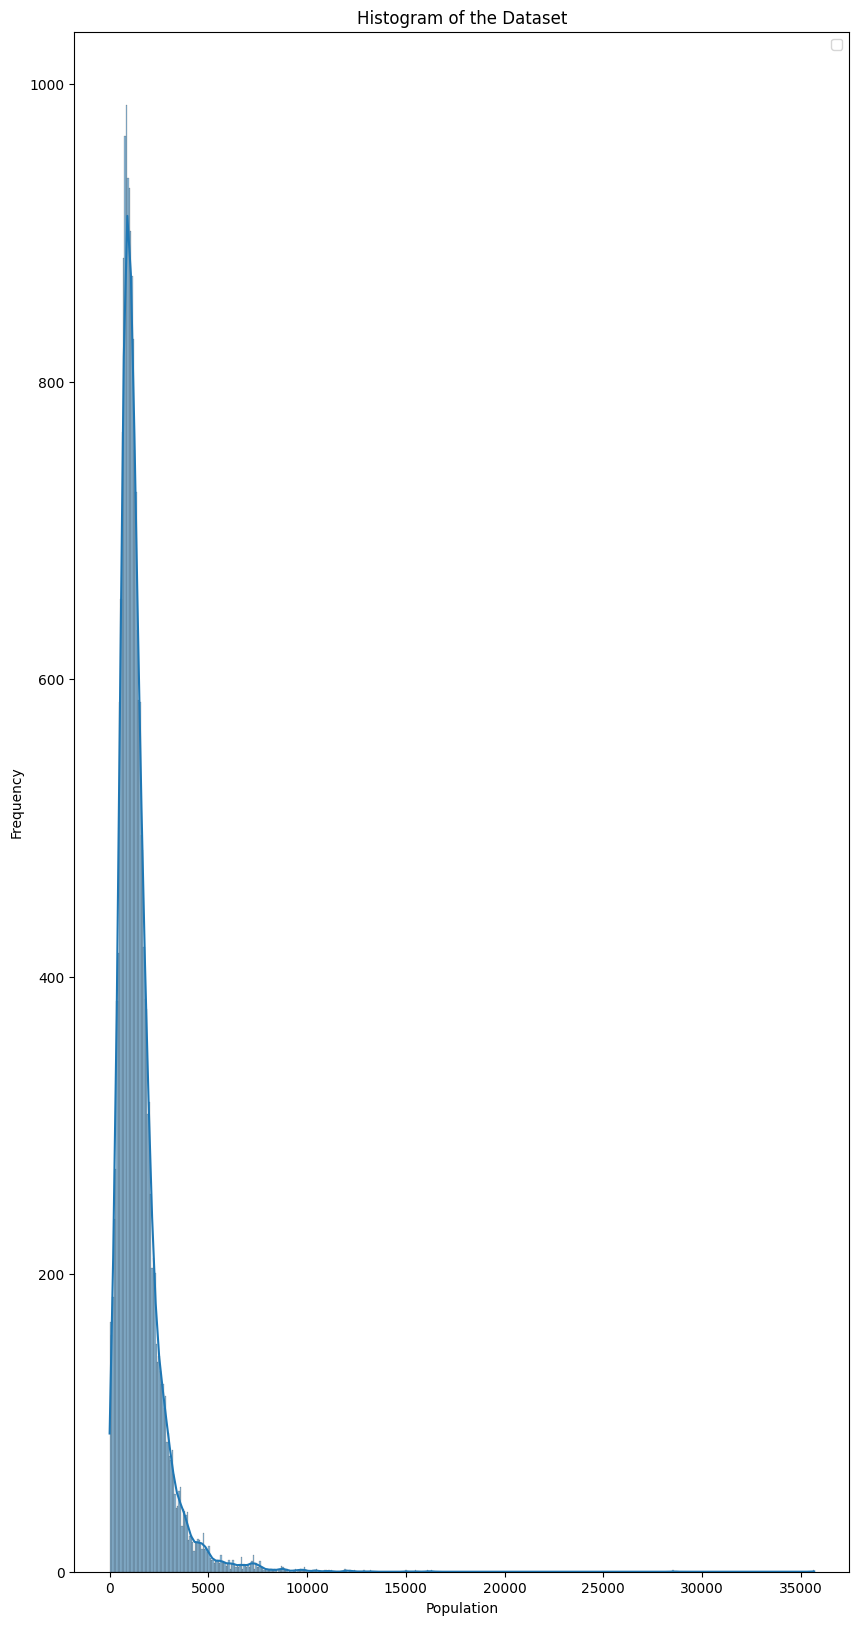

In [550]:
plt.figure(figsize=(10,20))
sns.histplot(df1['Population'],kde = True)
plt.title("Histogram of the Dataset")
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.legend()
plt.show()

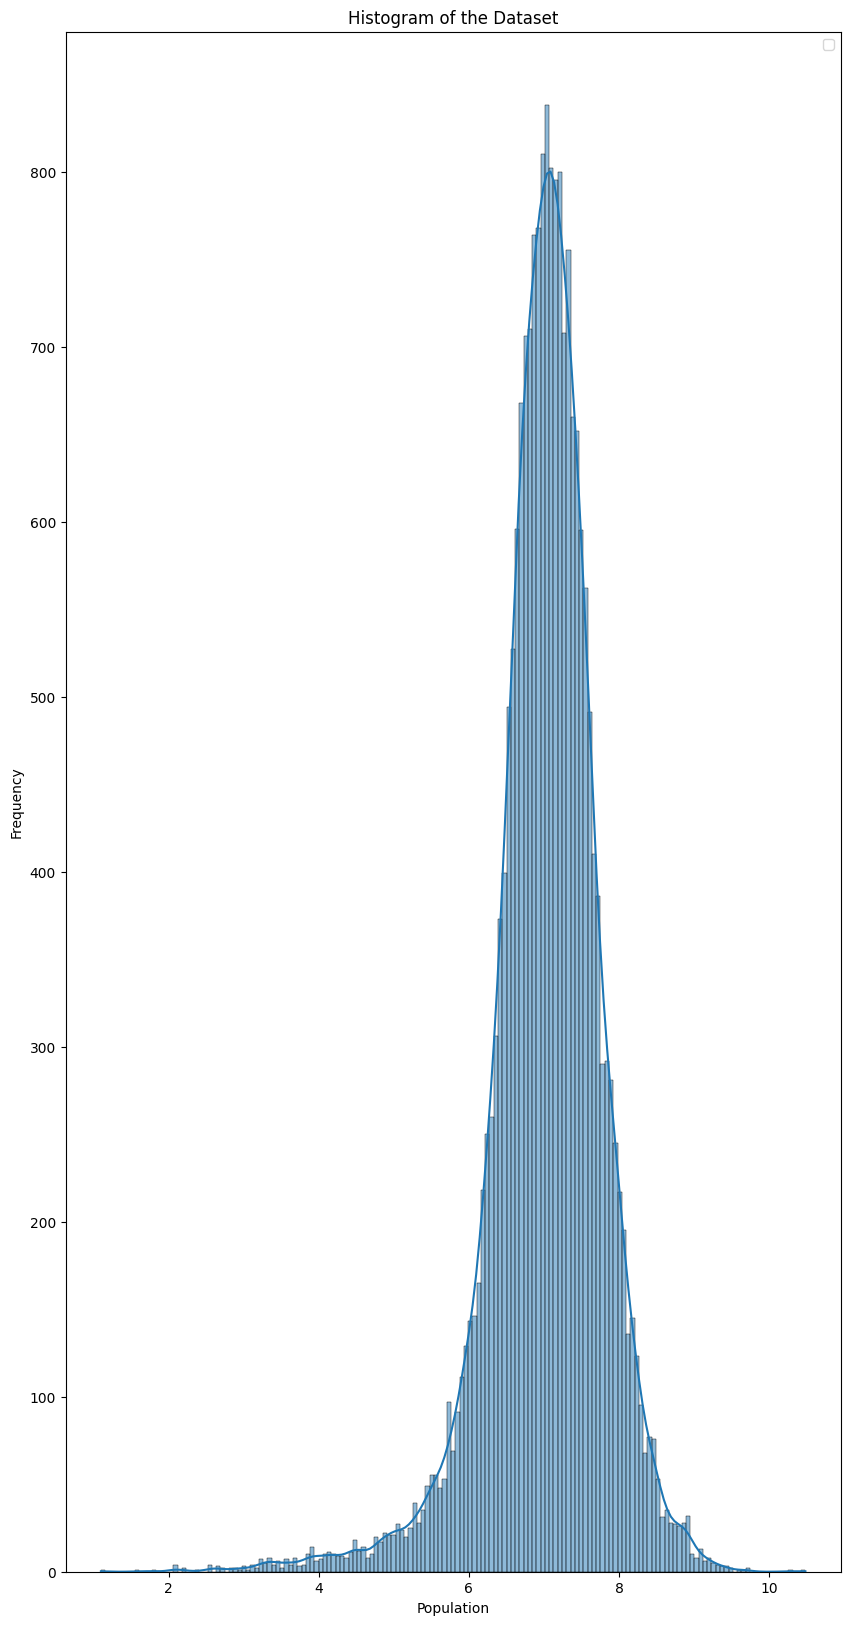

In [551]:
df1['Population'] = np.log(df1['Population'])
plt.figure(figsize=(10,20))
sns.histplot(df1['Population'],kde = True)
plt.title("Histogram of the Dataset")
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.legend()
plt.show()

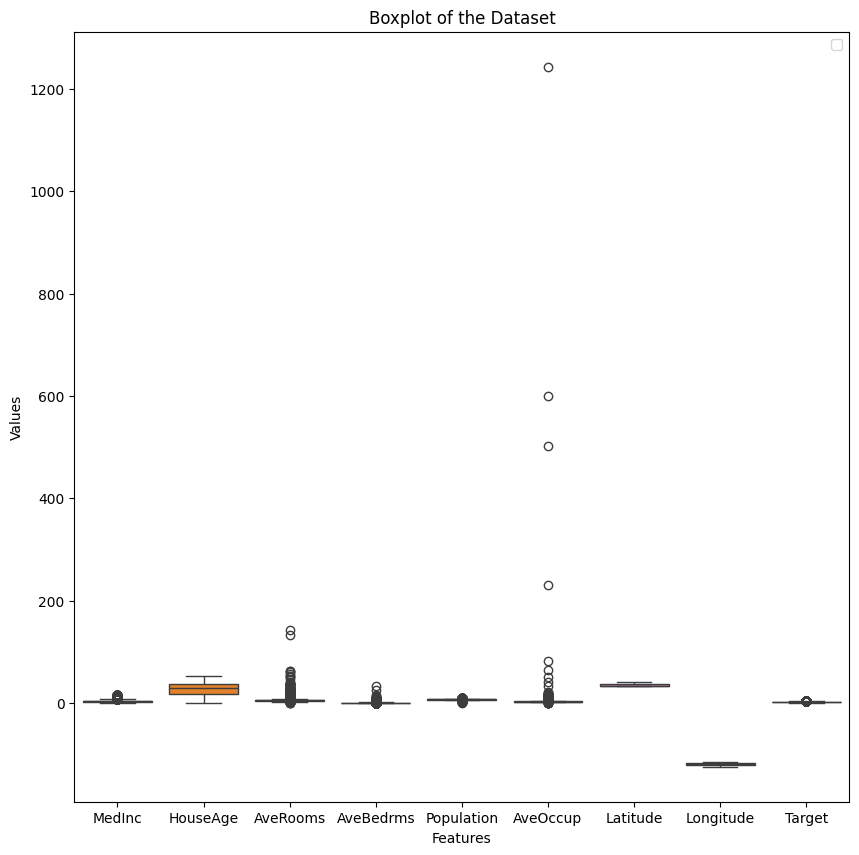

In [552]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df1)
plt.title("Boxplot of the Dataset")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.show()

In [553]:
data = load_diabetes()
X2 = pd.DataFrame(data.data, columns=data.feature_names)
y2 = data.target

In [554]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [555]:
X2.isnull().sum()

,0
age,0
sex,0
bmi,0
bp,0
s1,0
s2,0
s3,0
s4,0
s5,0
s6,0


In [556]:
std = StandardScaler()
X2 = std.fit_transform(X2)
df2 = pd.concat([pd.DataFrame(X2, columns=data.feature_names),pd.DataFrame(y2,columns=["Target"])],axis=1)
df2

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989,151.0
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479,75.0
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154,141.0
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823,206.0
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.876870,1.065488,0.413360,1.256040,-0.119769,-0.053957,-0.602843,-0.054499,0.655787,0.151508,178.0
438,-0.115937,1.065488,-0.334410,-1.422086,1.037341,1.664355,-0.602843,0.721302,-0.380819,0.935254,104.0
439,0.876870,1.065488,-0.334410,0.363573,-0.785107,-0.290965,-0.525441,-0.232934,-0.985649,0.325674,132.0
440,-0.956004,-0.938537,0.821235,0.025550,0.343075,0.321306,-0.602843,0.558384,0.936163,-0.545154,220.0


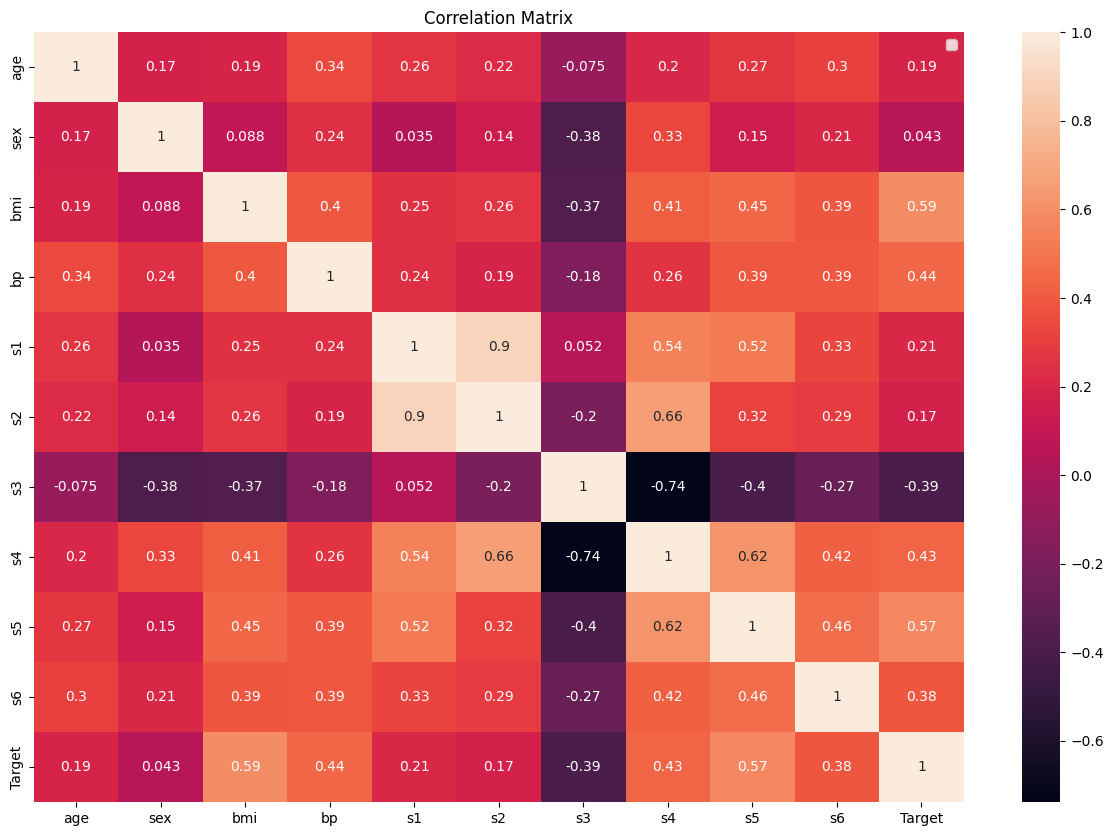

In [557]:
plt.figure(figsize=(15,10))
sns.heatmap(df2.corr(), annot=True)
plt.title("Correlation Matrix")
plt.legend()
plt.show()

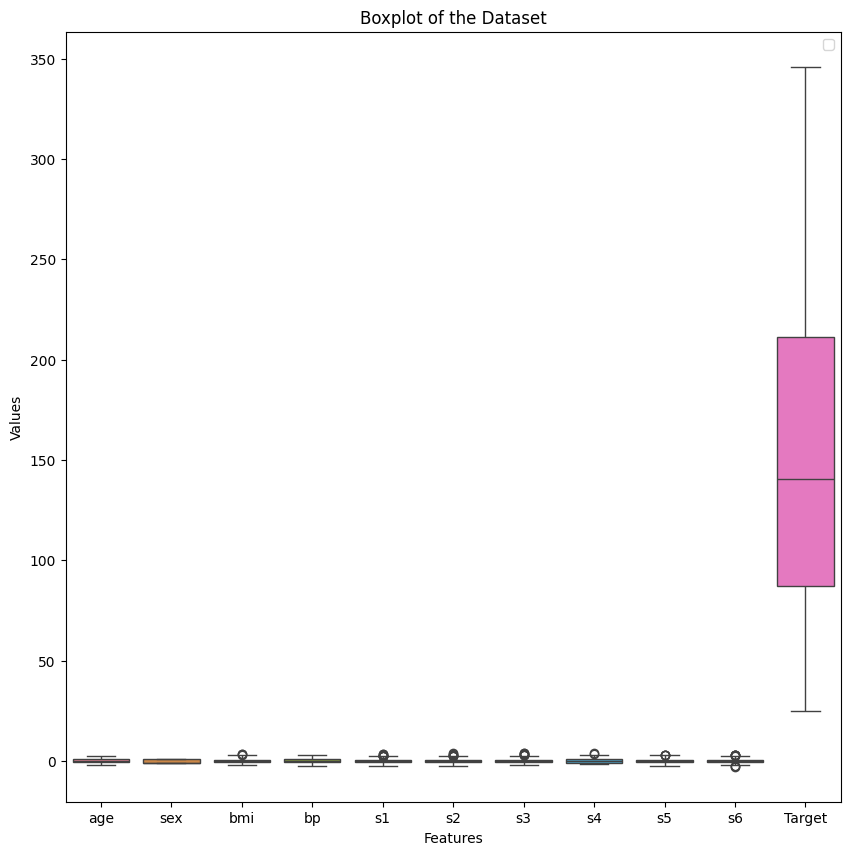

In [558]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df2)
plt.title("Boxplot of the Dataset")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.show()

In [559]:
df3 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
X3 = df3.drop("quality", axis=1)
y3 = df3["quality"]
df3

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [560]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [561]:
df3.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


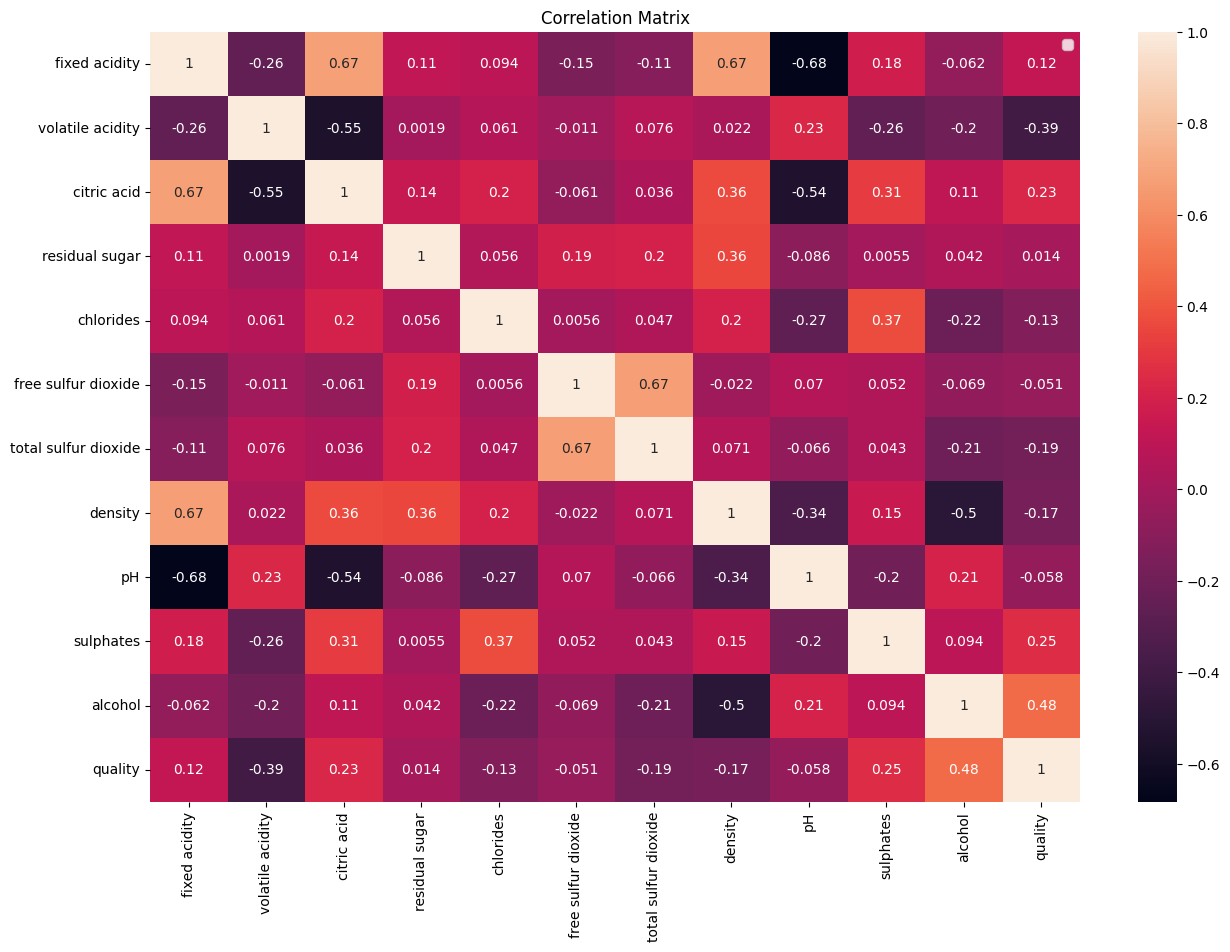

In [562]:
plt.figure(figsize=(15,10))
sns.heatmap(df3.corr(), annot=True)
plt.title("Correlation Matrix")
plt.legend()
plt.show()

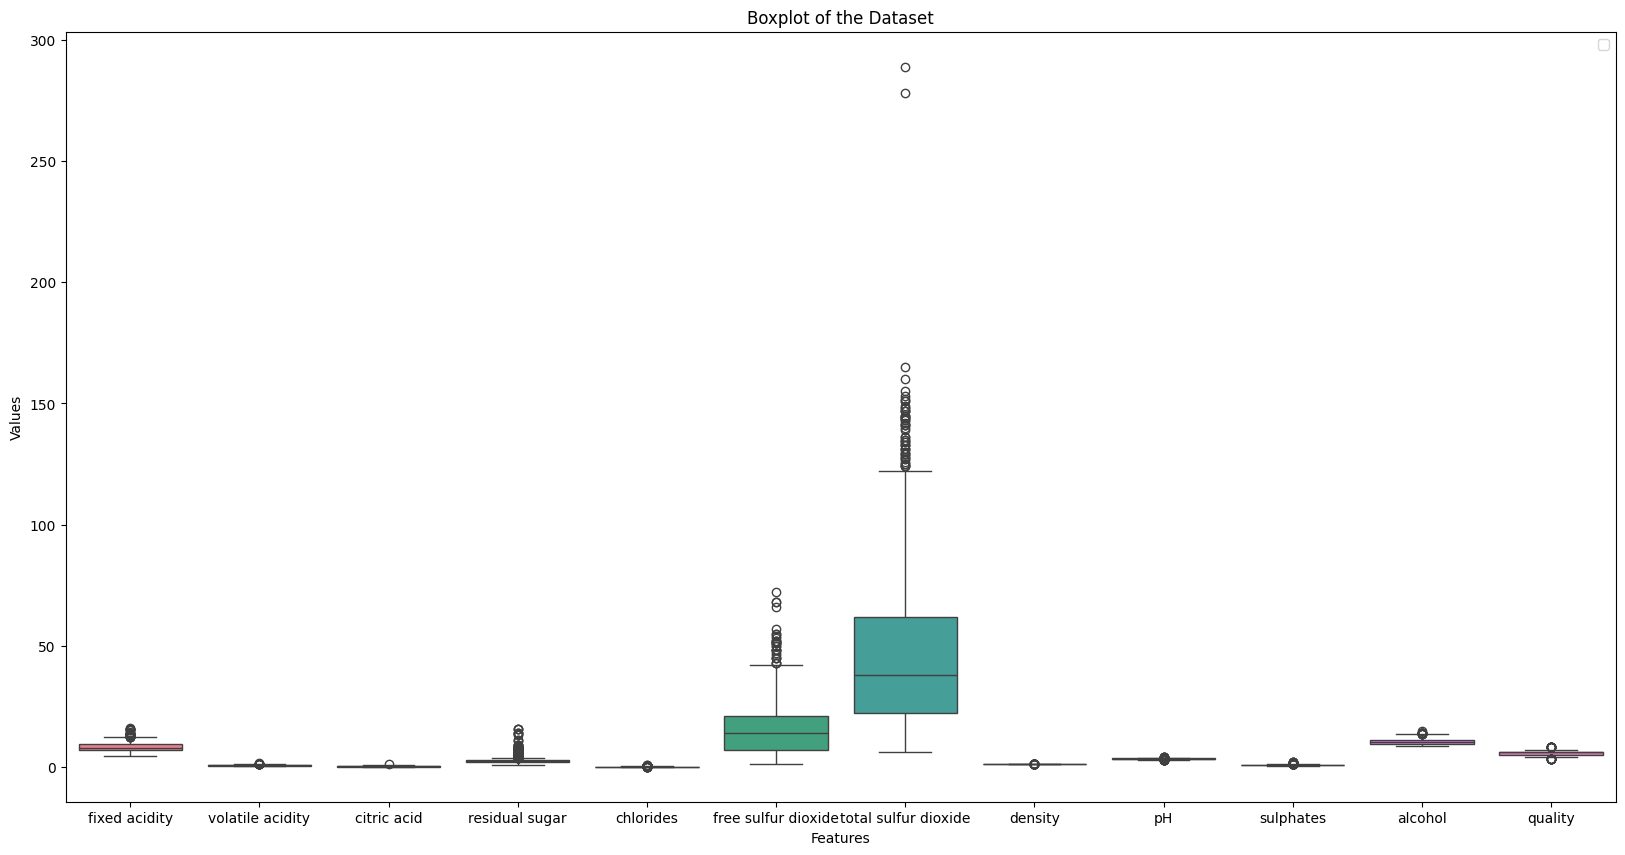

In [563]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df3)
plt.title("Boxplot of the Dataset")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.show()

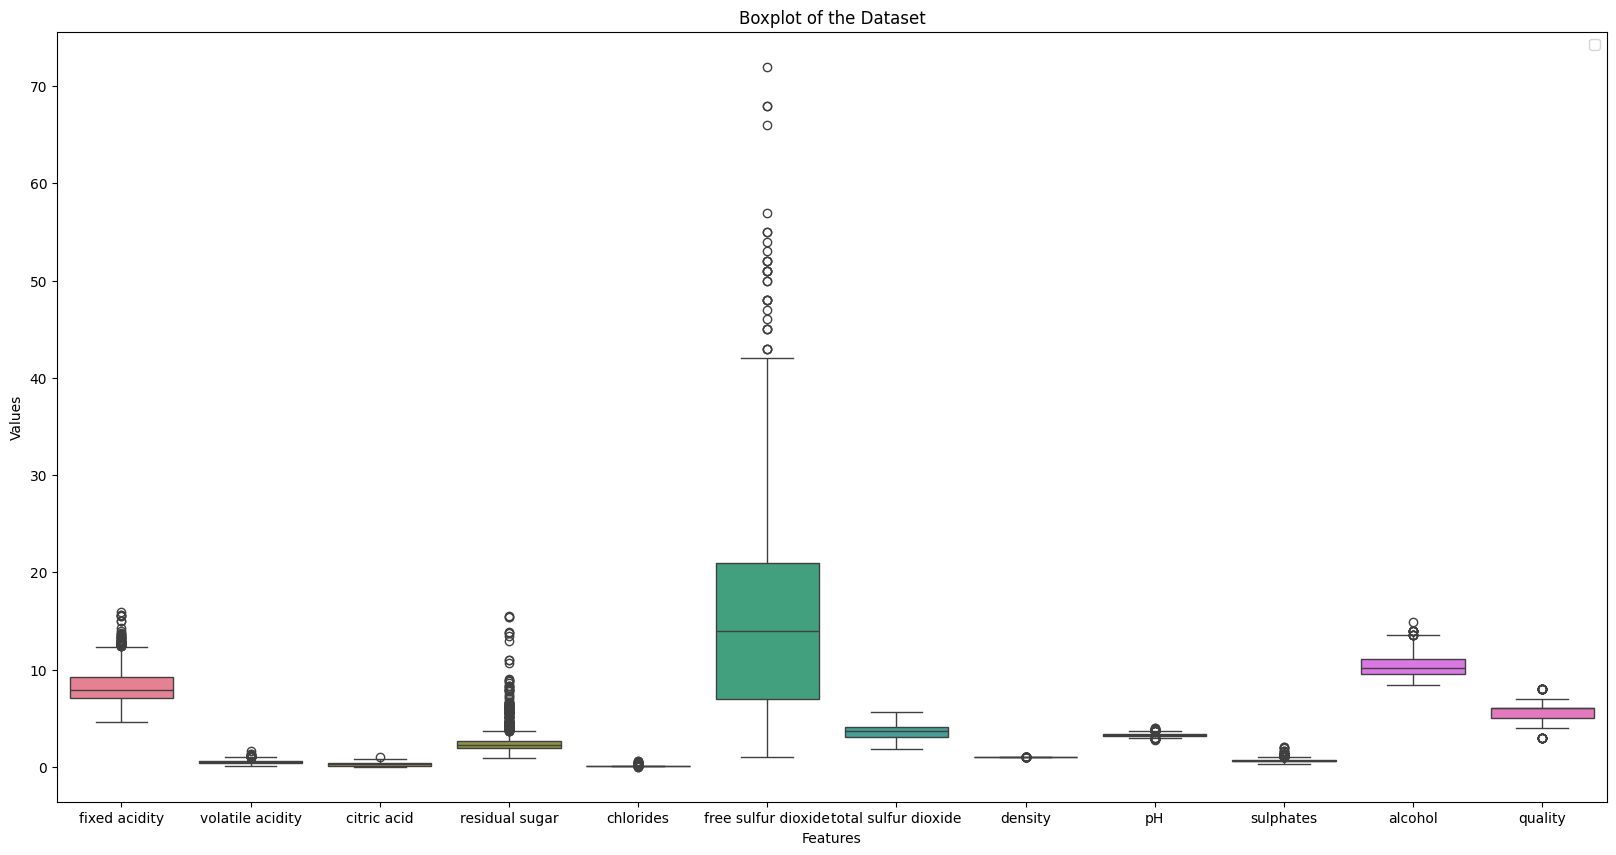

In [564]:
df3['total sulfur dioxide'] = np.log(df3['total sulfur dioxide'])
plt.figure(figsize=(20,10))
sns.boxplot(data=df3)
plt.title("Boxplot of the Dataset")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()
plt.show()

In [565]:
X1 = df1.drop("Target", axis=1)
y1 = df1["Target"]
X2 = df2.drop("Target", axis=1)
y2 = df2["Target"]
X3 = df3.drop("quality", axis=1)
y3 = df3["quality"]

###**Applying Linear Regression(OLS)**

In [566]:
linreg = LinReg_OLS()
linreg.fit(X1,y1)
y_pred_1 = linreg.predict(X1)
print("Mean Absolute Error: ",mean_abs_err(y1,y_pred_1))
print("Root Mean Square Error: ",root_mean_sqr_err(y1,y_pred_1))
print("R2 Value: ",r2_score(y1,y_pred_1))

Mean Absolute Error:  0.5310497675567348
Root Mean Square Error:  0.7240532519985208
R2 Value:  0.6062836592072982


In [567]:
linreg = LinReg_OLS()
linreg.fit(X2,y2)
y_pred_2 = linreg.predict(X2)
print("Mean Absolute Error: ",mean_abs_err(y2,y_pred_2))
print("Root Mean Square Error: ",root_mean_sqr_err(y2,y_pred_2))
print("R2 Value: ",r2_score(y2,y_pred_2))

Mean Absolute Error:  43.27745202531506
Root Mean Square Error:  53.47612876402657
R2 Value:  0.5177484222203499


In [568]:
linreg = LinReg_OLS()
linreg.fit(X3,y3)
y_pred_3 = linreg.predict(X3)
print("Mean Absolute Error: ",mean_abs_err(y3,y_pred_3))
print("Root Mean Square Error: ",root_mean_sqr_err(y3,y_pred_3))
print("R2 Value: ",r2_score(y3,y_pred_3))

Mean Absolute Error:  0.5039444916728917
Root Mean Square Error:  0.648018543745352
R2 Value:  0.3557019681694077


###**Applying Lasso Regression**

In [569]:
lasso = LassoReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X1 = std.fit_transform(X1)
lasso.fit(X1,y1)
y_pred_1 = lasso.predict(X1)
print("Mean Absolute Error: ",mean_abs_err(y1,y_pred_1))
print("Root Mean Square Error: ",root_mean_sqr_err(y1,y_pred_1))
print("R2 Value: ",r2_score(y1,y_pred_1))

Mean Absolute Error:  0.5323137489481955
Root Mean Square Error:  0.7250180320675087
R2 Value:  0.6052337288416756


In [570]:
lasso = LassoReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X2 = std.fit_transform(X2)
lasso.fit(X2,y2)
y_pred_2 = lasso.predict(X2)
print("Mean Absolute Error: ",mean_abs_err(y2,y_pred_2))
print("Root Mean Square Error: ",root_mean_sqr_err(y2,y_pred_2))
print("R2 Value: ",r2_score(y2,y_pred_2))

Mean Absolute Error:  43.2749975524865
Root Mean Square Error:  53.48211435829796
R2 Value:  0.517640459138698


In [571]:
lasso = LassoReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X3 = std.fit_transform(X3)
lasso.fit(X3,y3)
y_pred_3 = lasso.predict(X3)
print("Mean Absolute Error: ",mean_abs_err(y3,y_pred_3))
print("Root Mean Square Error: ",root_mean_sqr_err(y3,y_pred_3))
print("R2 Value: ",r2_score(y3,y_pred_3))

Mean Absolute Error:  0.5057648418922278
Root Mean Square Error:  0.6485404163722333
R2 Value:  0.35466379756982125


###**Applying Ridge Regression**

In [572]:
lasso = RidgeReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X1 = std.fit_transform(X1)
lasso.fit(X1,y1)
y_pred_1 = lasso.predict(X1)
print("Mean Absolute Error: ",mean_abs_err(y1,y_pred_1))
print("Root Mean Square Error: ",root_mean_sqr_err(y1,y_pred_1))
print("R2 Value: ",r2_score(y1,y_pred_1))

Mean Absolute Error:  0.5318022410929129
Root Mean Square Error:  0.7253813218760788
R2 Value:  0.6048380131833095


In [573]:
lasso = RidgeReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X2 = std.fit_transform(X2)
lasso.fit(X2,y2)
y_pred_2 = lasso.predict(X2)
print("Mean Absolute Error: ",mean_abs_err(y2,y_pred_2))
print("Root Mean Square Error: ",root_mean_sqr_err(y2,y_pred_2))
print("R2 Value: ",r2_score(y2,y_pred_2))

Mean Absolute Error:  43.34184803085305
Root Mean Square Error:  53.540904837177024
R2 Value:  0.5165794040492708


In [574]:
lasso = RidgeReg(lr=0.01,lambda_par=0.01,n_iters=10000)
std = StandardScaler()
X3 = std.fit_transform(X3)
lasso.fit(X3,y3)
y_pred_3 = lasso.predict(X3)
print("Mean Absolute Error: ",mean_abs_err(y3,y_pred_3))
print("Root Mean Square Error: ",root_mean_sqr_err(y3,y_pred_3))
print("R2 Value: ",r2_score(y3,y_pred_3))

Mean Absolute Error:  0.5042606849435285
Root Mean Square Error:  0.6480395452507891
R2 Value:  0.35566020563648426


#**Task 3**

###**K-Means Clustering**

**Data Loading**

In [575]:
df4 = pd.read_csv('/content/Mall_Customers.csv')

In [576]:
df4

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [577]:
num_data = df4.select_dtypes(include = 'number')
num_data.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,2,21,15,81
2,3,20,16,6
3,4,23,16,77
4,5,31,17,40


In [578]:
num_data.skew()

,0
CustomerID,0.000000
Age,0.485569
Annual Income (k$),0.321843
Spending Score (1-100),-0.047220


**Applying Square root transformation**

In [579]:
sqrt_income = np.sqrt(df4['Annual Income (k$)'])
df4['sqrt_income'] = sqrt_income
print("Annual Income data skewness before applying sqaure root transformation:",df4['Annual Income (k$)'].skew())
print("Annual Income data skewness after applying sqaure root transformation:",df4['sqrt_income'].skew())

Annual Income data skewness before applying sqaure root transformation: 0.3218425498619055
Annual Income data skewness after applying sqaure root transformation: -0.23028952579486217


**Doing Scaling using Standard Scaler**

In [580]:
scaler = StandardScaler()
scaled_sqrt_income = scaler.fit_transform(sqrt_income.values.reshape(-1,1))
df4['scaled_sqrt_income'] = scaled_sqrt_income
x = df4['scaled_sqrt_income'].mean()
y = df4['scaled_sqrt_income'].std()
print("Annual Income data skewness before before standard scaling:",df4['sqrt_income'].skew())
print("Annual Income data skewness after standard scaling:",df4['scaled_sqrt_income'].skew())
print("Annual Income data mean after standard scaling:",x)
print("Annual Income data standard deviation after standard scaling:",y)

Annual Income data skewness before before standard scaling: -0.23028952579486217
Annual Income data skewness after standard scaling: -0.23028952579486087
Annual Income data mean after standard scaling: -4.263256414560601e-16
Annual Income data standard deviation after standard scaling: 1.0025094142341708


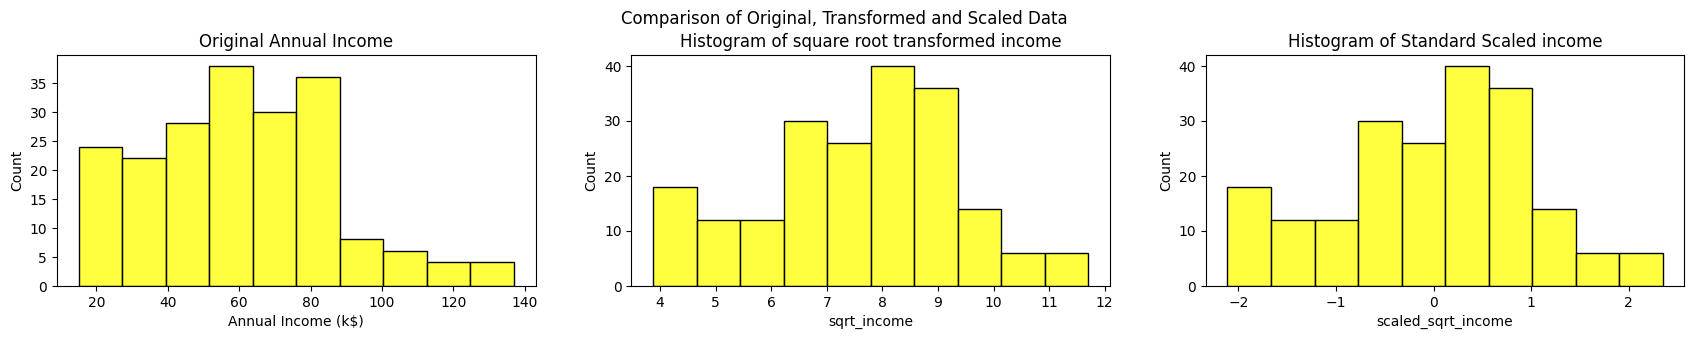

In [581]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows = 1,ncols = 3,figsize = (21,3))
sns.histplot(df4['Annual Income (k$)'],ax = ax1,color = 'yellow')
sns.histplot(df4['sqrt_income'],ax = ax2,color = 'yellow')
sns.histplot(df4['scaled_sqrt_income'],ax = ax3,color = 'yellow')
ax1.set_title("Original Annual Income")
ax2.set_title("Histogram of square root transformed income")
ax3.set_title("Histogram of Standard Scaled income")
plt.suptitle("Comparison of Original, Transformed and Scaled Data",y = 1.03)
plt.show()

**Using Elbow method to see optimal K**

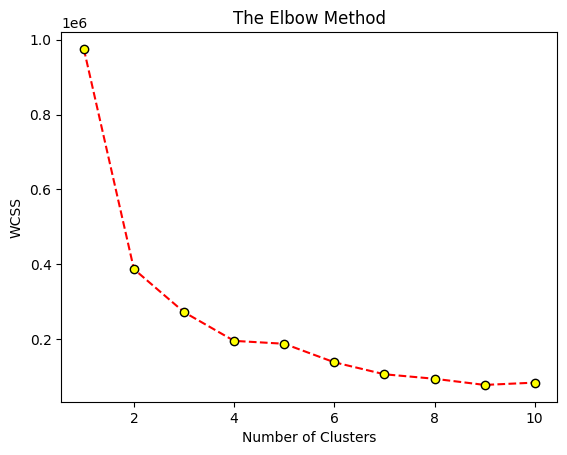

In [582]:
wcss = []
for k in range(1,11):
  wcss.append(KMeans(k_clusters = k,max_iters = 1000).fit(num_data).wcss())
plt.plot(range(1,11),wcss,marker = 'o',linestyle = '--',color = 'red',mfc = 'yellow',mec = 'k')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

**Performing K-Means Clustering**

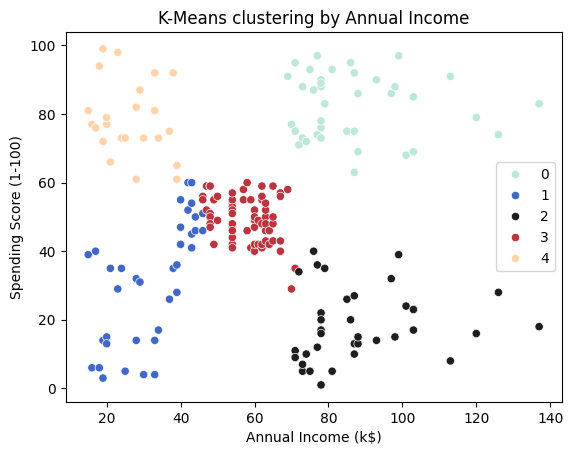

In [602]:
X = num_data.values
kmeans = KMeans(k_clusters = 5,max_iters = 1000).fit(X)
df4['cluster'] = kmeans.predict(X)
sns.scatterplot(data = df4,x= 'Annual Income (k$)',y ='Spending Score (1-100)' ,hue = 'cluster',palette = 'icefire')
plt.title("K-Means clustering by Annual Income")
plt.legend()
plt.show()

# **Task 4**

**Loading the Dataset**

In [584]:
iris = load_iris()
X5 = np.array(iris.data)
y5 = np.array(iris.target)
X5 = pd.DataFrame(X5, columns=iris.feature_names)
y5 = pd.DataFrame(y5, columns=["Target"])
df5 = pd.concat([X5,y5],axis=1)
df5

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [585]:
df5.dtypes

,0
sepal length (cm),float64
sepal width (cm),float64
petal length (cm),float64
petal width (cm),float64
Target,int64


**Applying the Decision Treee Classification Model**

In [586]:
tree = DecisionTreeClassifier(min_samples_split=10, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(df5.drop("Target", axis=1), df5["Target"], test_size=0.2, random_state=42)
y_train_reshaped = y_train.values.reshape(-1, 1)
tree.fit(X_train,y_train_reshaped)
X_test_np = X_test.values.astype(float)
y_pred = tree.predict(X_test_np)

**Evaluation of Decision Tree Classifier**

In [587]:
print(accuracy_score(y_test, y_pred))


0.9666666666666667


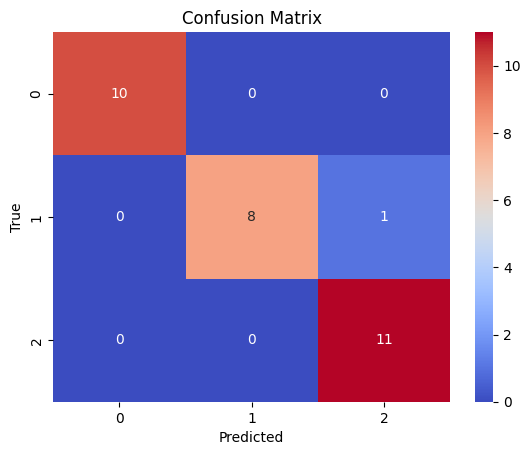

In [588]:
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()